# **Setup**

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarthakvijaysukhral","key":"373357cfae8b24cf1ac9344ca80f1333"}'}

# **Data and Preprocessing**

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
os.makedirs("data/RAVDESS", exist_ok=True)
os.makedirs("data/TESS", exist_ok=True)
# RAVDESS
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip -q ravdess-emotional-speech-audio.zip -d data/RAVDESS

# TESS
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip -q toronto-emotional-speech-set-tess.zip -d data/TESS


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 96% 410M/429M [00:00<00:00, 367MB/s]
100% 429M/429M [00:01<00:00, 437MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 98% 418M/428M [00:01<00:00, 233MB/s]
100% 428M/428M [00:01<00:00, 314MB/s]


In [4]:
#Extract features from audio
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean


In [5]:
#Load dataset
def load_dataset(folder_path):
    features = []
    labels = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion_label = get_emotion_label(file, root)  # We’ll define this function
                mfccs = extract_features(file_path)
                features.append(mfccs)
                labels.append(emotion_label)

    return np.array(features), np.array(labels)


In [6]:
#Label Extraction Logic
def get_emotion_label(filename, root):
    if "RAVDESS" in root:
        emotions = {
            '01': 'neutral',
            '02': 'calm',
            '03': 'happy',
            '04': 'sad',
            '05': 'angry',
            '06': 'fearful',
            '07': 'disgust',
            '08': 'surprised'
        }
        emotion_code = filename.split('-')[2]
        return emotions.get(emotion_code, "unknown")

    elif "TESS" in root:
        for emotion in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad', 'surprise']:
            if emotion.lower() in root.lower():
                return emotion

    return "unknown"


# **Model Training**

In [8]:
# Loading features and labels from both datasets and combining
features1, labels1 = load_dataset("data/RAVDESS")
features2, labels2 = load_dataset("data/TESS")

features = np.concatenate((features1, features2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labels_encoded = to_categorical(le.fit_transform(labels))

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42
)


In [9]:
#Building Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(labels_encoded.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,298 (204.29 KB)

 Trainable params: 52,298 (204.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1379 - loss: 12.8298 - val_accuracy: 0.2188 - val_loss: 2.1729
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2324 - loss: 2.1252 - val_accuracy: 0.3314 - val_loss: 1.8641
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2964 - loss: 1.9138 - val_accuracy: 0.4587 - val_loss: 1.6021
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3787 - loss: 1.6654 - val_accuracy: 0.5354 - val_loss: 1.3018
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4683 - loss: 1.4624 - val_accuracy: 0.6362 - val_loss: 1.1238
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5329 - loss: 1.2913 - val_accuracy: 0.6562 - val_loss: 1.0158
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5669 - loss: 1.1683 - val_accuracy: 0.6710 - val_loss: 0.9267
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6177 - loss: 1.0241 - val_accuracy: 

# **Model Evaluation**

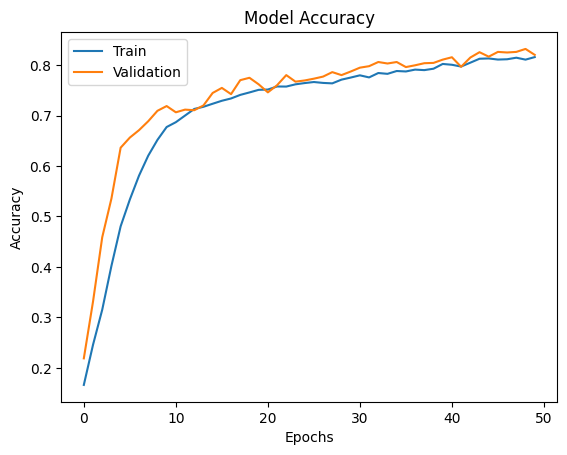

In [11]:
import pandas as pd

# Plot accuracy
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [13]:
#Save the model
model.save("ser_model.keras")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [15]:
#Inference function
def predict_emotion(file_path, model, label_encoder, max_pad_len=174):
    # Load and extract features
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]

    mfccs = mfccs.reshape(1, 40, max_pad_len, 1)

    # Predict
    prediction = model.predict(mfccs)
    predicted_index = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    return predicted_label